# (2022,arXiv)How Bad Are Artifacts?: Analyzing the Impact of Speech Enhancement Errors on ASR
https://arxiv.org/abs/2201.06685

In [203]:
from scipy.io import wavfile
import librosa

import numpy as np
from numpy.linalg import inv
from numpy.linalg import norm

import matplotlib.pyplot as plt   
import IPython.display as ipd

In [178]:
range(2,10)

range(2, 10)

In [193]:
path_noise = "data/wav/noise_1ch.wav"
path_noisy = "data/wav/noisy_1ch.wav"
path_speech = "data/wav/clean_1ch.wav"
path_enhan = "data/wav/t51.wav"
path_estim = "data/wav/estim.wav"

In [200]:
sr,n = wavfile.read(path_noise)
sr,s = wavfile.read(path_speech)
sr,s_hathat = wavfile.read(path_enhan)
sr,s_hat  = wavfile.read(path_estim)
sr,x = wavfile.read(path_noisy)

s_hathat = np.pad(s_hathat,(512,0))
s_hathat = s_hathat[:len(s)]

n = n/32768
s = s/32768
s_hat = s_hat/32768
s_hathat = s_hathat/32768
x = x/32768


print(s.shape)
print(s_hat.shape)
print(s_hathat.shape)
print(n.shape)
print(x.shape)

(104711,)
(104711,)
(104711,)
(104711,)
(104711,)


# Functions

In [192]:
def get(s,s_hat,n,T=1024,L=1,shift=1024,n_frame = 0):
    
    length = int(len(s)/shift)

    A_s = np.zeros((T,L))
    A_sn = np.zeros((T,2*L))
    eps_s = np.eye(L,L) * 1e-14
    eps_sn = np.eye(2*L,2*L) * 1e-14
    
    if n_frame == 0 :
        n_frame = length

    list_SDR = np.zeros(n_frame)
    list_SNR = np.zeros(n_frame)
    list_SAR = np.zeros(n_frame)

    for i in range(n_frame) :
        ## per frame
        idx = (i+10)*shift
        tmp_s = s[idx:idx+T]
        tmp_s_hat = s_hat[idx:idx+T]
        tmp_n = n[idx:idx+T]

        for j in range(L):
            A_s[j:,j] = s[:T-j]
            A_sn[j:,j] = s[:T-j]
            A_sn[j:,L+j] = n[:T-j]

        ## projection matrix
        # (2)
        P_s = A_s@inv(A_s.T@A_s + eps_s )@A_s.T
        # (3)
        P_sn = A_sn@inv(A_sn.T@A_sn + eps_sn)@A_sn.T

        # (4)
        s_target = P_s@tmp_s_hat
        # (5)
        e_noise  = P_sn@tmp_s_hat - P_s@tmp_s_hat
        # (6)
        e_artif = tmp_s_hat - P_sn@tmp_s_hat

        abs_target = np.sum(np.power(s_target,2))
        # 7
        SDR = 10*np.log10(abs_target/np.sum(np.power(e_noise + e_artif,2)))
        # 8
        SNR = 10*np.log10(abs_target/np.sum(np.power(e_noise,2)))
        # 9
        SAR = 10*np.log10(np.sum(np.power(s_target+e_noise,2))/np.sum(np.power(e_artif,2)))

        list_SDR[i] = SDR
        list_SNR[i] = SNR
        list_SAR[i] = SAR
    return list_SDR,list_SNR,list_SAR

In [228]:
def GET(s,s_hat,n,T=1024,L=1,shift=1024,n_frame = 0):
    
    length = s.shape[1]

    A_s = np.zeros((T,L))
    A_sn = np.zeros((T,2*L))
    eps_s = np.eye(L,L) * 1e-14
    eps_sn = np.eye(2*L,2*L) * 1e-14
    
    if n_frame == 0 :
        n_frame = length

    list_SDR = np.zeros(n_frame)
    list_SNR = np.zeros(n_frame)
    list_SAR = np.zeros(n_frame)

    for i in range(n_frame) :
        ## per frame
        idx = (i+10)*shift
        tmp_s = s[:,i]
        tmp_s_hat = s_hat[:,i]
        tmp_n = n[:,i]
        

        for j in range(L):
            A_s[:,j] = s[:,i+j]
            A_sn[:,j] = s[:,i+j]
            A_sn[:,L+j] = n[:,i+j]

        ## projection matrix
        # (2)
        P_s = A_s@inv(A_s.T@A_s + eps_s )@A_s.T
        # (3)
        P_sn = A_sn@inv(A_sn.T@A_sn + eps_sn)@A_sn.T

        # (4)
        s_target = P_s@tmp_s_hat
        # (5)
        e_noise  = P_sn@tmp_s_hat - P_s@tmp_s_hat
        # (6)
        e_artif = tmp_s_hat - P_sn@tmp_s_hat

        abs_target = np.sum(np.power(s_target,2))
        # 7
        SDR = 10*np.log10(abs_target/np.sum(np.power(e_noise + e_artif,2)))
        # 8
        SNR = 10*np.log10(abs_target/np.sum(np.power(e_noise,2)))
        # 9
        SAR = 10*np.log10(np.sum(np.power(s_target+e_noise,2))/np.sum(np.power(e_artif,2)))

        list_SDR[i] = SDR
        list_SNR[i] = SNR
        list_SAR[i] = SAR
    return list_SDR,list_SNR,list_SAR

# Display

## s

## n

## s hat

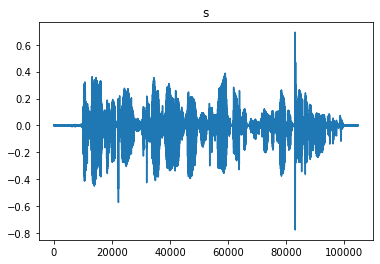

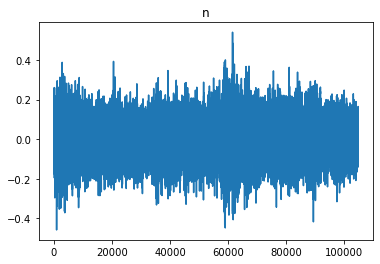

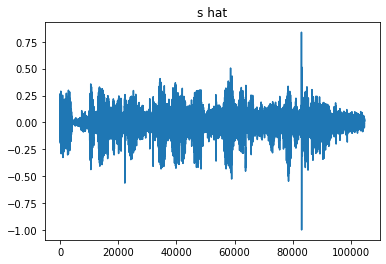

In [187]:
plt.figure()
plt.plot(s)
plt.title("s")
plt.figure()
plt.plot(n)
plt.title("n")
plt.figure()
plt.plot(s_hat)
plt.title("s hat")


ipd.display(ipd.Markdown('## s'))
ipd.display(ipd.Audio(s, rate=sr))
ipd.display(ipd.Markdown('## n'))
ipd.display(ipd.Audio(n, rate=sr))
ipd.display(ipd.Markdown('## s hat'))
ipd.display(ipd.Audio(s_hat, rate=sr))

# Orthogonal projection based decomposition

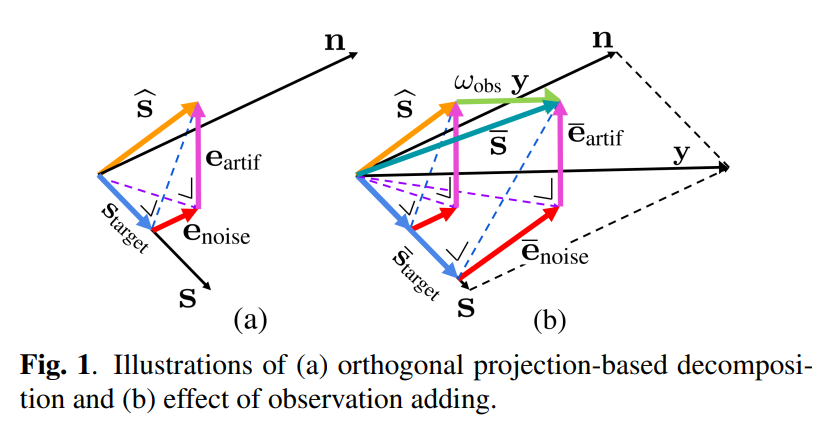

$$  \mathbf{P_s} = \mathbf{A_s}(\mathbf{A_s}^T\mathbf{A_s})^{-1}\mathbf{A_s}^T $$
$$  \mathbf{P_{s,n}} = \mathbf{A_{s,n}}(\mathbf{A_{s,n}}^T\mathbf{A_{s,n}})^{-1}\mathbf{A_{s,n}}^T $$

$$ \mathbf{A_s} = [\mathbf{s}^{\tau = 0}, . . . , \mathbf{s}^{\tau = L-1}] \in \mathbb{R} ^{T \times L} $$ 
$$ \mathbf{A_{s,n}} =  [\mathbf{s}^{\tau = 0}, . . . , \mathbf{s}^{\tau = L-1} , \mathbf{n}^{\tau = 0}, . . . , \mathbf{n}^{\tau = L-1}]  \in \mathbb{R} ^{T \times 2L} $$ 

$$ \mathbf{s}_\text{target} = \mathbf{P_s}\widehat{\mathbf{s}} $$
$$ \mathbf{e}_\text{noise} = \mathbf{P_{s,n}}\widehat{\mathbf{s}} -  \mathbf{P_s}\widehat{\mathbf{s}} $$
$$ \mathbf{e}_\text{artif} = \widehat{\mathbf{s}} -  \mathbf{P_{s,n}}\widehat{\mathbf{s}} $$

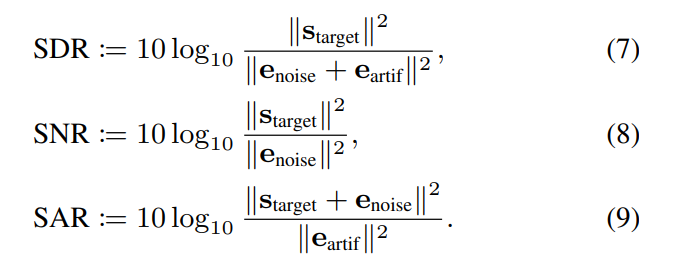

# artifacts on Time Domain

# s, x, n

Text(0.5, 1.0, 'SAR')

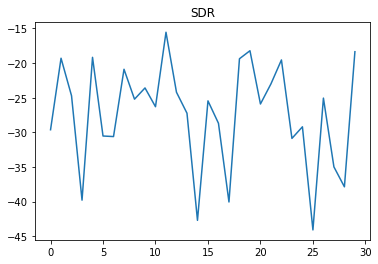

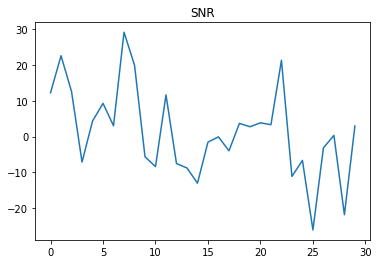

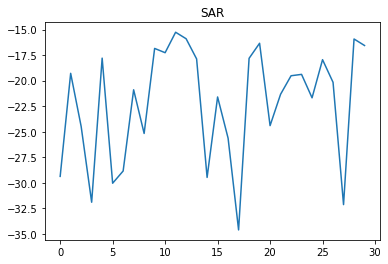

In [195]:
list_SDR,list_SNR,list_SAR = get(s,x,n,n_frame=30)

ipd.display(ipd.Markdown('# s, x, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hat, n

Text(0.5, 1.0, 'SAR')

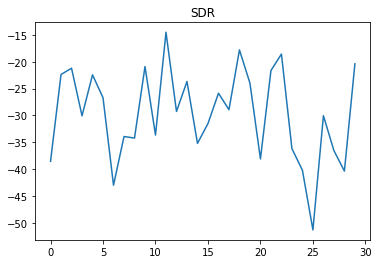

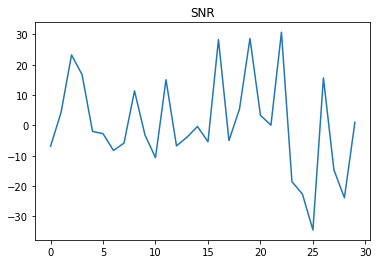

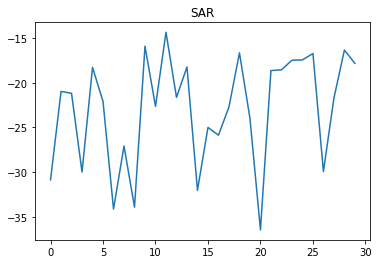

In [196]:
list_SDR,list_SNR,list_SAR = get(s,s_hat,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s, n

Text(0.5, 1.0, 'SAR')

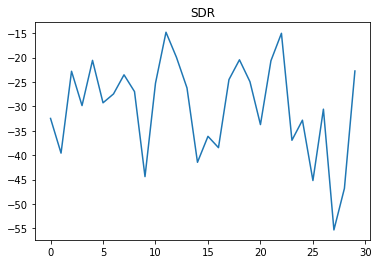

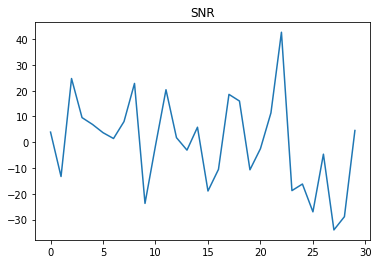

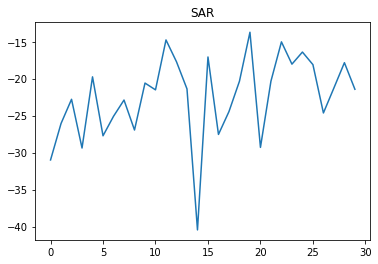

In [197]:
list_SDR,list_SNR,list_SAR = get(s,s,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hathat, n

Text(0.5, 1.0, 'SAR')

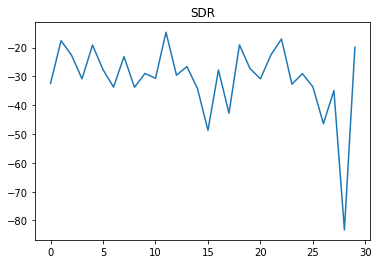

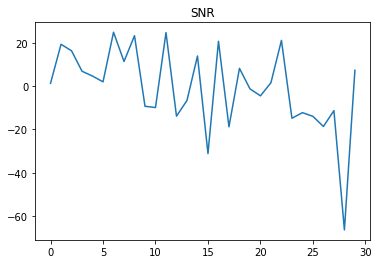

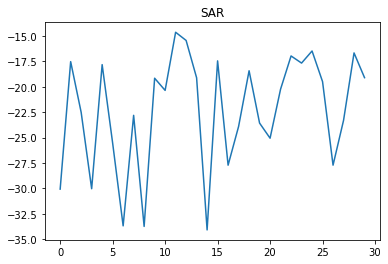

In [198]:
list_SDR,list_SNR,list_SAR = get(s,s_hathat,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hathat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, s_hathat, n, OA 0.3

Text(0.5, 1.0, 'SAR')

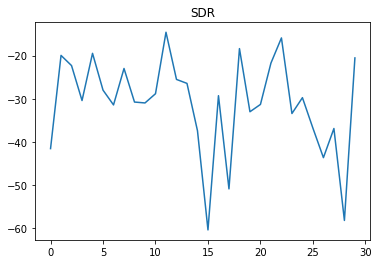

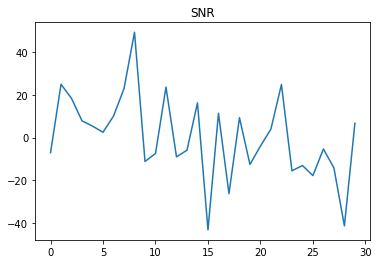

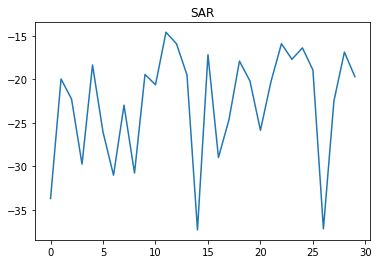

In [202]:
list_SDR,list_SNR,list_SAR = get(s,s_hathat+0.5*s,n,n_frame=30)

ipd.display(ipd.Markdown('# s, s_hathat, n, OA 0.3'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

In [146]:
x = np.array([1,2])
x

array([1, 2])

In [118]:
np.sum(np.power(x,2))

5

In [96]:
M = np.matrix([[1,2,3],[5,3,7],[1,5,8]])
print(M)
print(inv(M))
inv(M)@M


[[1 2 3]
 [5 3 7]
 [1 5 8]]
[[ 1.          0.09090909 -0.45454545]
 [ 3.         -0.45454545 -0.72727273]
 [-2.          0.27272727  0.63636364]]


matrix([[ 1.00000000e+00,  4.44089210e-16,  4.44089210e-16],
        [-2.22044605e-16,  1.00000000e+00,  0.00000000e+00],
        [ 1.11022302e-16,  1.11022302e-16,  1.00000000e+00]])

# TF domain

In [230]:
N = np.abs(librosa.stft(n))
S = np.abs(librosa.stft(s))
X = np.abs(librosa.stft(x))
S_hat = np.abs(librosa.stft(s_hat))
S_hathat = np.abs(librosa.stft(s_hathat))

print(N.shape)
print(S.shape)
print(X.shape)
print(S_hat.shape)
print(S_hathat.shape)

(1025, 205)
(1025, 205)
(1025, 205)
(1025, 205)
(1025, 205)


# s, S_hat, n

Text(0.5, 1.0, 'SAR')

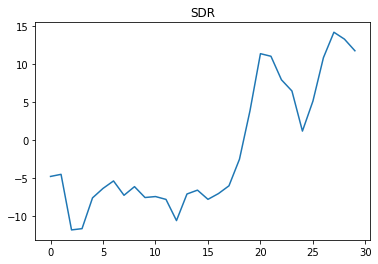

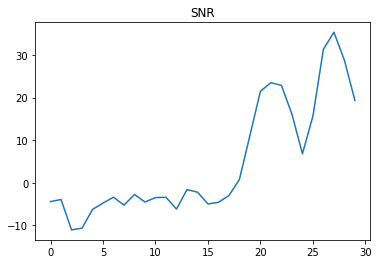

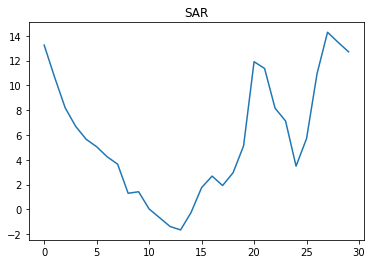

In [232]:
list_SDR,list_SNR,list_SAR = GET(S,S_hat,N,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S_hat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, X, n

Text(0.5, 1.0, 'SAR')

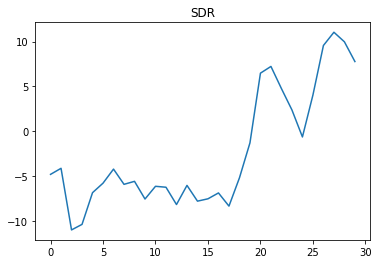

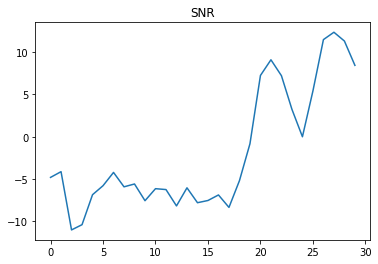

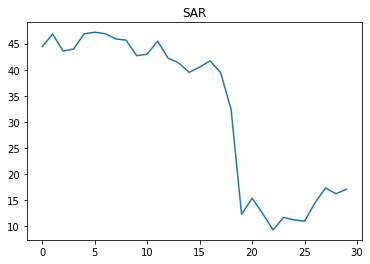

In [233]:
list_SDR,list_SNR,list_SAR = GET(S,X,N,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, X, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, S_hathat, n

Text(0.5, 1.0, 'SAR')

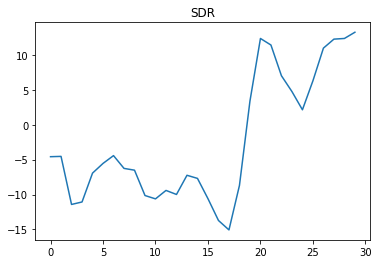

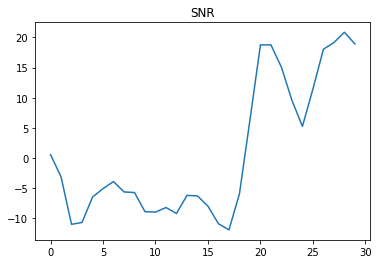

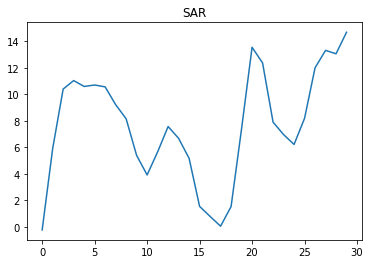

In [234]:
list_SDR,list_SNR,list_SAR = GET(S,S_hathat,N,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S_hathat, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")

# s, S, n

Text(0.5, 1.0, 'SAR')

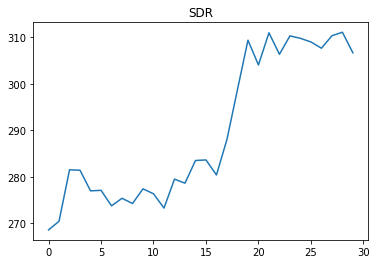

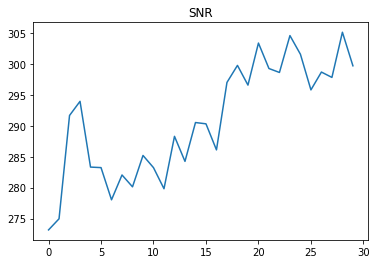

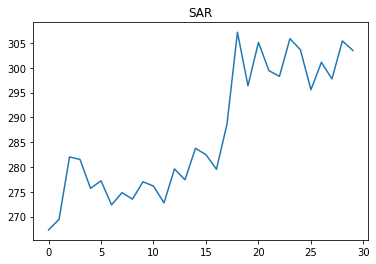

In [235]:
list_SDR,list_SNR,list_SAR = GET(S,S,N,T=1025,n_frame=30)

ipd.display(ipd.Markdown('# s, S, n'))

plt.figure()
plt.plot(list_SDR)
plt.title("SDR")

plt.figure()
plt.plot(list_SNR)
plt.title("SNR")

plt.figure()
plt.plot(list_SAR)
plt.title("SAR")